# Import data

In [5]:
import torch
from gensim import corpora

In [54]:
import sys,os
path = os.getcwd()
sys.path.insert(0, path)
import ner_util

In [55]:
Xtrain, Ytrain = ner_util.read_data('../data/train.tsv')
Xval, Yval = ner_util.read_data('../data/devel.tsv')

In [70]:
#Xtrain[100]

In [71]:
#Ytrain[100]

In [72]:
len(Xtrain)

4560

## Baseline sequence labeling model
This is the baseline model. You can expand on this when implementing your solution.

In [58]:
import torch
from torch import nn

class BaselineSequenceModel(nn.Module):
    
    def __init__(self, seq_labeler):
        super().__init__()                
        
        # Here is how you access the NERParameters.
        p = seq_labeler.params
        
        # The model consists of just a word embedding layer and a
        # linear output unit. We use the vocabulary to create the embedding layer.        
        self.word_embedding = seq_labeler.word_voc.make_embedding_layer(finetune=p.finetune_word_emb, 
                                                                        emb_dim=p.word_emb_dim)
        
        # The dimensionality of the word embedding model.
        word_emb_dim = self.word_embedding.weight.shape[1]
        
        # Output unit.
        self.top_layer = nn.Linear(word_emb_dim, seq_labeler.n_labels)
                        
    def forward(self, words):
        # words is a tensor of integer-encoded words, with shape (batch_size, max_sen_length)
                
        # After embedding the words, the shape is (batch_size, max_sen_length, emb_dim). 
        word_repr = self.word_embedding(words)
            
        # We predict the BIO label simply by applying a linear model to
        # the word embedding at that position.
        
        # The shape of the output is (batch_size, max_sen_length, n_labels),
        # where n_labels is the size of the output label vocabulary.
        return self.top_layer(word_repr)

## Training the system
As usual, we create an object that contains all hyperparameters.

In [59]:
class NERParameters:

    # Random seed, for reproducibility.
    random_seed = 0    
    
    # cuda or cpu
    device = 'cpu'
                
    # NB: this hyperparameter is only used if we are training the embedding
    # model from scratch.
    word_emb_dim = 128
    
    # Whether or not to fine-tune the word embedding model.
    finetune_word_emb = False

    # Training parameters
    n_epochs = 20
    batch_size = 32    
    learning_rate = 0.005
    weight_decay = 0

    # Word dropout rate.
    word_dropout_prob = 0.0
        
    # Set the following to True to enable character tensors.
    use_characters = False

Now, we are ready to train. When creating the NER system, the first argument should be the hyperparameter container. The second should be a function that builds the neural network; we just use the constructor of the class we defined above.

In [60]:
ner_system = ner_util.SequenceLabeler(NERParameters(), BaselineSequenceModel)
ner_system.fit(Xtrain, Ytrain, Xval, Yval)

Epoch 1: train loss = 1.1238, val f1: 0.1077, time = 0.5032
Epoch 2: train loss = 0.7464, val f1: 0.0617, time = 0.4773
Epoch 3: train loss = 0.5754, val f1: 0.0220, time = 0.4742
Epoch 4: train loss = 0.5067, val f1: 0.0311, time = 0.4969
Epoch 5: train loss = 0.4781, val f1: 0.0247, time = 0.4997
Epoch 6: train loss = 0.4647, val f1: 0.0192, time = 0.4987
Epoch 7: train loss = 0.4562, val f1: 0.0058, time = 0.4872
Epoch 8: train loss = 0.4520, val f1: 0.0264, time = 0.4833
Epoch 9: train loss = 0.4480, val f1: 0.0205, time = 0.5168
Epoch 10: train loss = 0.4446, val f1: 0.0060, time = 0.4914
Epoch 11: train loss = 0.4430, val f1: 0.0136, time = 0.5171
Epoch 12: train loss = 0.4421, val f1: 0.0142, time = 0.5268
Epoch 13: train loss = 0.4415, val f1: 0.0169, time = 0.5407
Epoch 14: train loss = 0.4404, val f1: 0.0012, time = 0.5190
Epoch 15: train loss = 0.4380, val f1: 0.0024, time = 0.4980
Epoch 16: train loss = 0.4377, val f1: 0.0098, time = 0.5044
Epoch 17: train loss = 0.4383, va

0.10774507002000572

Text(0.5, 1.0, 'Validation F-score')

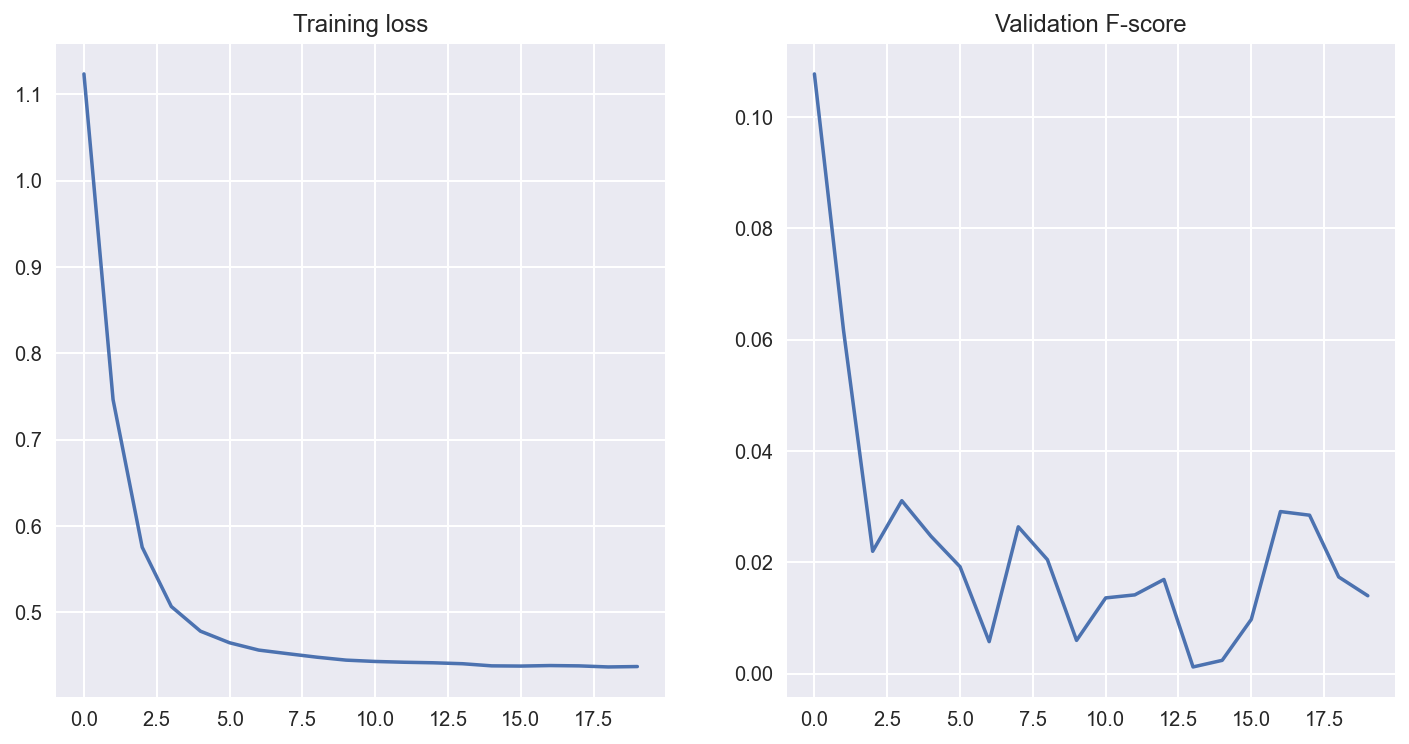

In [65]:
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina' 
plt.style.use('seaborn')

fig, ax = plt.subplots(1, 2, figsize=(2*6,1*6))
ax[0].plot(ner_system.history['train_loss']);
ax[0].set_title('Training loss')
ax[1].plot(ner_system.history['val_f1']);
ax[1].set_title('Validation F-score')

Predicting outputs:

In [68]:
ner_system.predict(['The patient suffered from bubonic plague and COVID-19 .'.split()])

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]

In [69]:
ner_util.show_entities(ner_system, ['The patient suffered from bubonic plague and COVID-19 .'.split()])